In [62]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-prediction-problem-dataset/test_Y3wMUE5_7gLdaTN.csv
/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv


In [63]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [64]:
# Step 1: Load the dataset
df = pd.read_csv('/kaggle/input/loan-prediction-problem-dataset/train_u6lujuX_CVtuZ9i.csv')

In [65]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [66]:
df.shape

(614, 13)

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [68]:
df.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [69]:
df.duplicated().sum()

0

In [70]:
# Fill missing values
df['Gender'] = df['Gender'].fillna(df['Gender'].mode()[0])
df['Married'] = df['Married'].fillna(df['Married'].mode()[0])
df['Dependents'] = df['Dependents'].fillna(df['Dependents'].mode()[0])
df['Self_Employed'] = df['Self_Employed'].fillna(df['Self_Employed'].mode()[0])
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0])
df['Credit_History'] = df['Credit_History'].fillna(df['Credit_History'].mode()[0])


In [71]:
df.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [72]:
# Check for duplicates
duplicates = df.duplicated()
num_duplicates = duplicates.sum()

print(f"Number of duplicate rows: {num_duplicates}")
if num_duplicates > 0:
    print("Duplicate rows:")
    print(df[duplicates])
else:
    print("No duplicate rows found.")


Number of duplicate rows: 0
No duplicate rows found.


In [73]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,614.000000,614.000000,614.000000
mean,5403.459283,1621.245798,145.752443,342.410423,0.855049
std,6109.041673,2926.248369,84.107233,64.428629,0.352339
min,150.000000,0.000000,9.000000,12.000000,0.000000
25%,2877.500000,0.000000,100.250000,360.000000,1.000000
50%,3812.500000,1188.500000,128.000000,360.000000,1.000000
75%,5795.000000,2297.250000,164.750000,360.000000,1.000000
max,81000.000000,41667.000000,700.000000,480.000000,1.000000


In [74]:
# Encode categorical variables
label_encoder = LabelEncoder()
for column in ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Loan_Status']:
    df[column] = label_encoder.fit_transform(df[column])

In [75]:
# Define features and target variable
X = df.drop(columns=['Loan_ID', 'Loan_Status'])
y = df['Loan_Status']

In [76]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [77]:
# Initialize models
log_reg = LogisticRegression(max_iter=1000)
dt_classifier = DecisionTreeClassifier()
rf_classifier = RandomForestClassifier()


In [78]:
# Train models
log_reg.fit(X_train, y_train)
dt_classifier.fit(X_train, y_train)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

**Model Evaluation**

In [79]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Evaluate Logistic Regression
y_pred_log_reg = log_reg.predict(X_test)
print("Logistic Regression Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print(classification_report(y_test, y_pred_log_reg))

Logistic Regression Metrics:
Accuracy: 0.7886178861788617
              precision    recall  f1-score   support

           0       0.95      0.42      0.58        43
           1       0.76      0.99      0.86        80

    accuracy                           0.79       123
   macro avg       0.85      0.70      0.72       123
weighted avg       0.83      0.79      0.76       123



In [80]:
# Evaluate Decision Tree
y_pred_dt = dt_classifier.predict(X_test)
print("\nDecision Tree Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print(classification_report(y_test, y_pred_dt))


Decision Tree Metrics:
Accuracy: 0.7235772357723578
              precision    recall  f1-score   support

           0       0.62      0.56      0.59        43
           1       0.77      0.81      0.79        80

    accuracy                           0.72       123
   macro avg       0.69      0.69      0.69       123
weighted avg       0.72      0.72      0.72       123



In [81]:
# Evaluate Random Forest
y_pred_rf = rf_classifier.predict(X_test)
print("\nRandom Forest Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))


Random Forest Metrics:
Accuracy: 0.7642276422764228
              precision    recall  f1-score   support

           0       0.82      0.42      0.55        43
           1       0.75      0.95      0.84        80

    accuracy                           0.76       123
   macro avg       0.79      0.68      0.70       123
weighted avg       0.78      0.76      0.74       123



**Visualization**

In [82]:
import matplotlib.pyplot as plt
import seaborn as sns

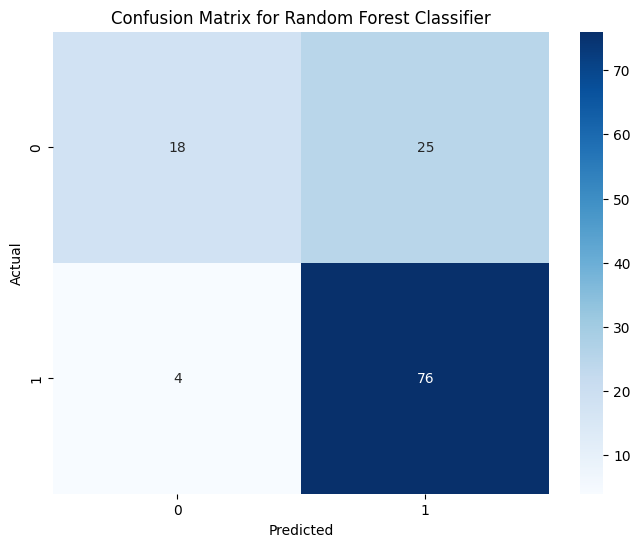

In [83]:
# Plot confusion matrix for Random Forest
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix for Random Forest Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [84]:
# Compare model accuracies
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest']
accuracies = [
    accuracy_score(y_test, y_pred_log_reg),
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_rf)
]

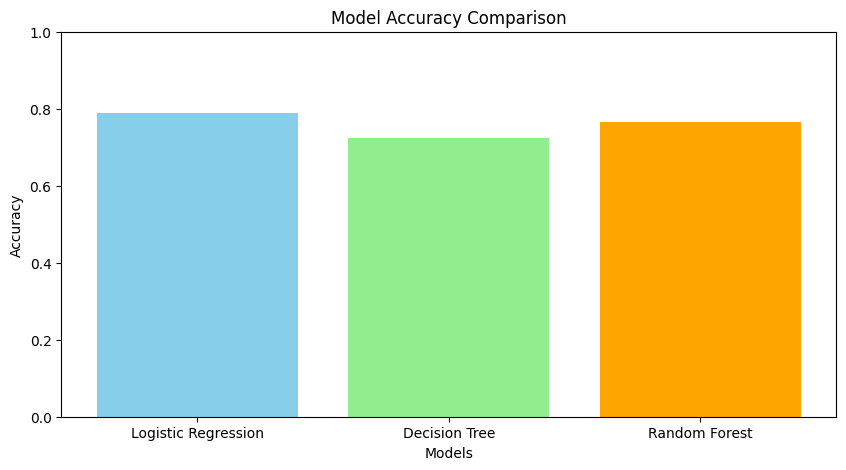

In [85]:
plt.figure(figsize=(10, 5))
plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'orange'])
plt.title("Model Accuracy Comparison")
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.show()